In [15]:
import json
import networkx as nx
import numpy as np

import functions
%config InlineBackend.figure_format = "svg"

from importlib import reload

In [16]:
reload(functions)

<module 'functions' from 'c:\\Users\\alsty\\Desktop\\Diploma Thesis\\functions.py'>

In [17]:
#function to read .json file of the input graph
def readPreferenceGraph(filePath) :
    with open(filePath) as file :
        data = json.load(file)

    G = nx.MultiDiGraph()

    for edge in data["edges"] :
        G.add_edge(edge["source"], edge["target"], opinion=edge["opinion"], questionItem=edge["question item"])
    
    return G

In [18]:
def createInteractionGraph(preferenceGraph, threshold, maxInteractions, maxTimestamp) :
    n = preferenceGraph.number_of_nodes()
    # activitiesCount = 6

    interactionGraph = []
    interactionGraphIntensity = []
    
    degrees = [0] * n
   
        
    # list of possible peers to inteact for each person
    possiblePeers = functions.analyzeQuiz(prefGraph=preferenceGraph, \
                                          threshold=threshold, \
                                          numNodes=n)
    
    # ------------------------------------- #
    #    interactions at timetsamp t = 0    #
    # ------------------------------------- #
    # 1st step: interactions based on a scale-free network model with m=3
    interactionGraph.append(nx.barabasi_albert_graph(n=preferenceGraph.number_of_nodes(), \
                                                     m=3))

    # 2nd step: add random activities as weights
    for u, v in interactionGraph[0].edges() :
        interactionGraph[0][u][v]["weight"] = np.random.choice(range(1, 7))
    
    # 3rd step: calculate intensity
    snapshotIntensity = functions.calculateIntensityForSnapshot(snapshotGraph=interactionGraph[0], 
                                                                numNodes=n)
    interactionGraphIntensity.append(snapshotIntensity)

    # 4th step: add snapshot degrees to the total number of degrees
    for node in range(n) :
        degrees[node] += interactionGraph[0].degree(node) 
    

    # -------------------------------------- #
    #    interactions at timetsamp t >= 1    #
    # -------------------------------------+ #
    for time in range(1, maxTimestamp + 1) :
        
        # 1st step: create new snapshot
        # 2nd step: add activities as weights
        snapshot = functions.createSnapshot(numNodes=n, \
                                            maxInteractions=maxInteractions, \
                                            possiblePeers=possiblePeers)
        interactionGraph.append(snapshot)
        
        # 3rd step: calculate intensity
        snapshotIntensity = functions.calculateIntensityForSnapshot(snapshotGraph=interactionGraph[time], \
                                                                    numNodes=n)
        interactionGraphIntensity.append(snapshotIntensity)
        
        # 4th step: add snapshot degrees to the total number of degrees
        for node in range(n) :
            degrees[node] += interactionGraph[time].degree(node) 
        
    
    # calculate indexes for each snapshot
    graphSequenceIndexes = []
    for time in range(maxTimestamp + 1) :
        snapshotIndexes = functions.calculateIndexes(prefGraph=preferenceGraph, \
                                                     snapshotGraph=interactionGraph[time], \
                                                     numNodes=n)
        graphSequenceIndexes.append(snapshotIndexes)

    
    return {
        "graph" : interactionGraph,
        "sequence intensity": interactionGraphIntensity,
        "individual": {
            "popularity": np.average([item["individual"]["popularity"] for item in graphSequenceIndexes]),
            "antipathy": np.average([item["individual"]["antipathy"] for item in graphSequenceIndexes]),
            "affective connection": np.average([item["individual"]["affective connection"] for item in graphSequenceIndexes]),
            "sociometric status": np.average([item["individual"]["sociometric status"] for item in graphSequenceIndexes]),
            "positive expansion": np.average([item["individual"]["positive expansion"] for item in graphSequenceIndexes]),
            "negative expansion": np.average([item["individual"]["negative expansion"] for item in graphSequenceIndexes]),
            "realistic perception": np.average([item["individual"]["realistic perception"] for item in graphSequenceIndexes])
        },
        "group": {
            "association": np.average([item["group"]["association"] for item in graphSequenceIndexes]),
            "dissociation": np.average([item["group"]["dissociation"] for item in graphSequenceIndexes]),
            "cohesion": np.average([item["group"]["cohesion"] for item in graphSequenceIndexes]),
            "social intensity": np.average([item["group"]["social intensity"] for item in graphSequenceIndexes]),
        }
    }

In [19]:
path = "./preferenceGraph.json"

options = {
    "threshold" : 0.4,
    "maxInteractions" : 4,
    "maxTimestamp" : 15
}

G = createInteractionGraph(preferenceGraph=readPreferenceGraph(path), **options)

print("\033[1mSnapshots added...\033[0m")
for i in range(6) :
    print(f"at t = {i}: {G['graph'][i]}")

print("\n\033[1mGraph Sequence Intensity\033[0m")
print(G['sequence intensity'])

print("\n\033[1mIndividual Indexes\033[0m")
print(G["individual"])

print("\n\033[1mGroup Indexes\033[0m")
print(G["group"])

Snapshots added...
at t = 0: Graph with 100 nodes and 291 edges
at t = 1: Graph with 100 nodes and 176 edges
at t = 2: Graph with 100 nodes and 182 edges
at t = 3: Graph with 100 nodes and 182 edges
at t = 4: Graph with 100 nodes and 182 edges
at t = 5: Graph with 100 nodes and 181 edges

Graph Sequence Intensity
[17489, 4404, 4699, 4721, 4793, 4582, 4662, 4563, 4355, 4579, 4691, 4619, 4600, 4800, 4501, 4769]

Individual Indexes
{'popularity': 0.012345328282828283, 'antipathy': 0.006862373737373738, 'affective connection': 0.2624648112304362, 'sociometric status': 0.003942550505050504, 'positive expansion': 0.012345328282828284, 'negative expansion': 0.006862373737373738, 'realistic perception': 0.2438544815151094}

Group Indexes
{'association': 0.003446969696969697, 'dissociation': 0.0008017676767676768, 'cohesion': 0.27937981737543083, 'social intensity': 0.01920770202020202}


In [20]:
timestamp = 1
print(f"\033[1mInteraction activities at timestamp = {timestamp}\033[0m")
for i, j, data in G["graph"][timestamp].edges(data=True) :
    print(f"({i},{j}) => interaction No. {data['weight']}: {functions.getActivity(data['weight'])}")

Interaction activities at timestamp = 1
(0,2) => interaction No. 1: to share content, chat in a social network platform
(0,56) => interaction No. 3: to play games
(0,40) => interaction No. 5: to be volunteers
(0,21) => interaction No. 5: to be volunteers
(1,8) => interaction No. 2: to participate in debate/group discussion & presentation
(1,23) => interaction No. 3: to play games
(1,14) => interaction No. 5: to be volunteers
(1,12) => interaction No. 3: to play games
(2,3) => interaction No. 1: to share content, chat in a social network platform
(2,45) => interaction No. 3: to play games
(2,76) => interaction No. 6: to be teammates in a sports team
(3,6) => interaction No. 1: to share content, chat in a social network platform
(3,5) => interaction No. 4: to study in group or work on collaborative projects
(3,9) => interaction No. 5: to be volunteers
(4,15) => interaction No. 1: to share content, chat in a social network platform
(4,58) => interaction No. 4: to study in group or work on

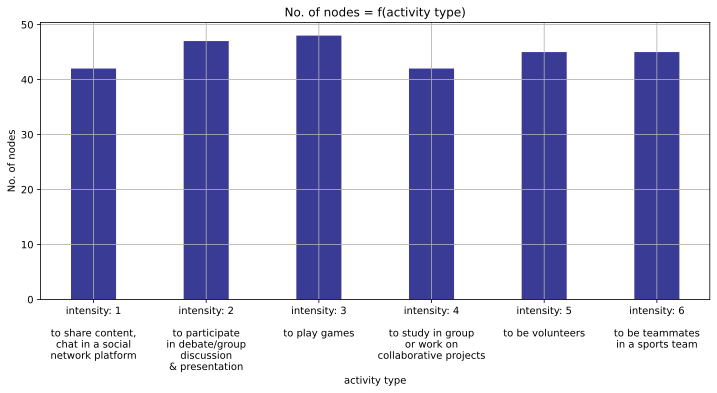

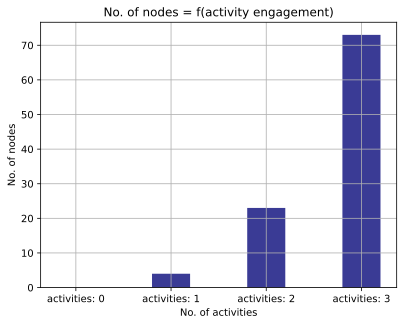

In [21]:
functions.findActivitiesStatistics(G["graph"][1])